<a href="https://colab.research.google.com/github/aymanxp/Multi-Class-Classification-Neural-Network/blob/main/multiClass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 38.5 MB/s eta 0:00:00


In [ ]:
#Set up device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

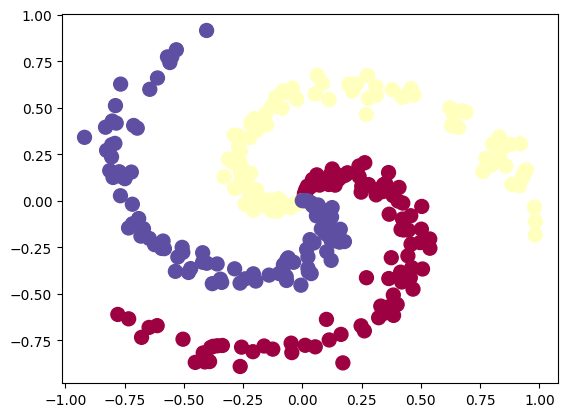

In [ ]:
# Create data :
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = y
df.head()

,x1,x2,y
0,0.000000,0.000000,0
1,0.003266,0.009558,0
2,0.009145,0.018014,0
3,0.010884,0.028281,0
4,0.009077,0.039371,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2)

In [ ]:
class classication_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=3)
    )
  def forward(self, X):
    return self.layer_stack(X)

In [ ]:
model = classication_model().to(device)
model

classication_model(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:
# Turn data to tensors :
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

In [ ]:
# Create loss function and optimizer :
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=3).to(device)

In [ ]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model.train()
  # 1. forward pass
  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc*100:.2f}% | Test loss: {test_loss:.2f} Test acc: {test_acc*100:.2f}%")

Epoch: 0 | Loss: 1.11 Acc: 31.67% | Test loss: 1.09 Test acc: 40.00%
Epoch: 100 | Loss: 0.96 Acc: 55.83% | Test loss: 0.96 Test acc: 58.33%
Epoch: 200 | Loss: 0.76 Acc: 51.25% | Test loss: 0.69 Test acc: 61.67%
Epoch: 300 | Loss: 0.68 Acc: 57.08% | Test loss: 0.60 Test acc: 65.00%
Epoch: 400 | Loss: 0.64 Acc: 60.00% | Test loss: 0.56 Test acc: 66.67%
Epoch: 500 | Loss: 0.58 Acc: 65.83% | Test loss: 0.53 Test acc: 70.00%
Epoch: 600 | Loss: 0.52 Acc: 71.67% | Test loss: 0.49 Test acc: 71.67%
Epoch: 700 | Loss: 0.46 Acc: 75.83% | Test loss: 0.44 Test acc: 78.33%
Epoch: 800 | Loss: 0.40 Acc: 79.58% | Test loss: 0.38 Test acc: 80.00%
Epoch: 900 | Loss: 0.34 Acc: 83.75% | Test loss: 0.32 Test acc: 85.00%


In [ ]:
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


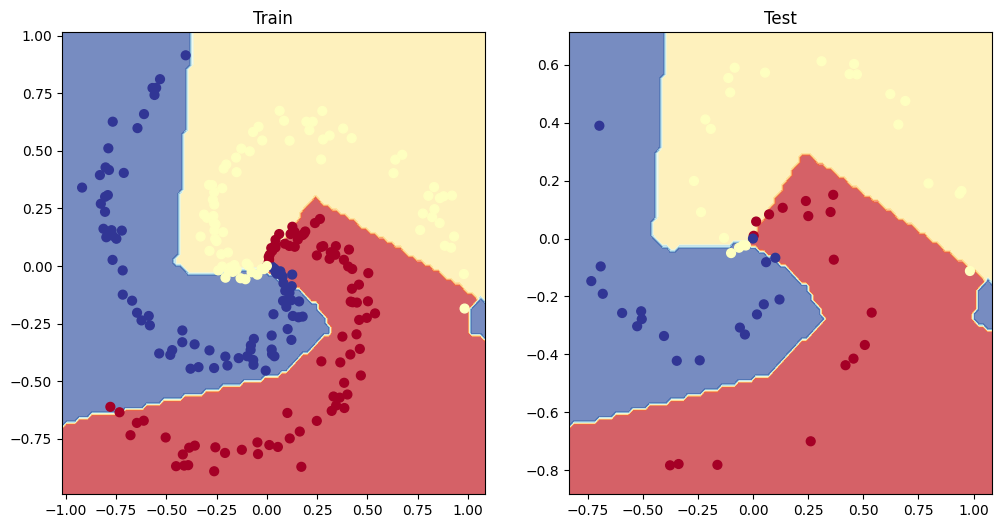

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)